# Value-at-Risk
Value at Risk - VaR - is one of the most important metrics that is used to measures the risk associated with a financial position or a portfolio of financial instruments. VaR can be defined as the maximum loss with a confidence level over a predetermined period. Let's say that the **1-Day 95% VaR** of our portfolio is 100 dollars 
 . This means that 95% of the time, it is expected that - under normal market conditions - we will not lose more than $100 by holding our portfolio over one day.

Three approaches that are commonly used in the industry are:

- Parametric
- Historical Simulation
- Monte Carlo Simulation

### Import Libraries

In [151]:
import pandas as pd
import numpy as np
from functools import reduce
from numpy.linalg import multi_dot

from scipy.stats import norm
from tabulate import tabulate

import matplotlib.pyplot as plt

### Data Preprocessing

In [152]:
# file names and the resp. ticker symbols
ticker_symbols = {
    'AAPL.csv': 'AAPL',
    'AMZN.csv': 'AMZN',
    'META.csv': 'META',
    'NFLX.csv': 'NFLX',
    'GOOG.csv': 'GOOG',
}

def process_df_close(file, ticker):
    df = pd.read_csv(file, usecols=['Date', 'Close'], index_col='Date', parse_dates=True)
    df = df.rename(columns={"Close":f"{ticker}"})
    return df

dfs_close_list = [process_df_close(file, ticker) for file, ticker in ticker_symbols.items()]
df_close = pd.concat(dfs_close_list, axis=1).dropna()
df_close.sort_index(inplace=True, ascending=False)

# function to read and process each csv

def process_stocks_log_return(file, ticker):
    # read the 'Date' and 'Close' columns, with 'Date' as index
    df = pd.read_csv(file, usecols=['Date', 'Close'], index_col='Date', parse_dates=True)
    # calc the log returns and drop the Nan vals that may arise from the calc
    df[f'{ticker}'] = np.log(df['Close'] / df['Close'].shift(1)).dropna()
    # drop the original 'Close' column, keeping only the log retuns column
    df.drop(columns=['Close'], inplace=True)
    return df

# process each stock csv and store in list
log_return_dfs = [process_stocks_log_return(file, ticker) for file, ticker in ticker_symbols.items()]

# outer join to merge all dfs on 'Date' col
df_log_ret = pd.concat(log_return_dfs, axis=1).dropna()

df_log_ret.sort_index(inplace=True, ascending=False)

df_close.head(8)

,AAPL,AMZN,META,NFLX,GOOG
Date,,,,,
2024-04-03,169.649994,182.410004,506.739990,630.080017,156.369995
2024-04-02,168.839996,180.690002,497.369995,614.210022,155.869995
2024-04-01,170.029999,180.970001,491.350006,614.309998,156.500000
2024-03-28,171.479996,180.380005,485.579987,607.330017,152.259995
2024-03-27,173.309998,179.830002,493.859985,613.530029,151.940002
2024-03-26,169.710007,178.300003,495.890015,629.239990,151.699997
2024-03-25,170.850006,179.710007,503.019989,627.460022,151.149994
2024-03-22,172.279999,178.869995,509.579987,628.010010,151.770004


### Visualize Daily Log Returns

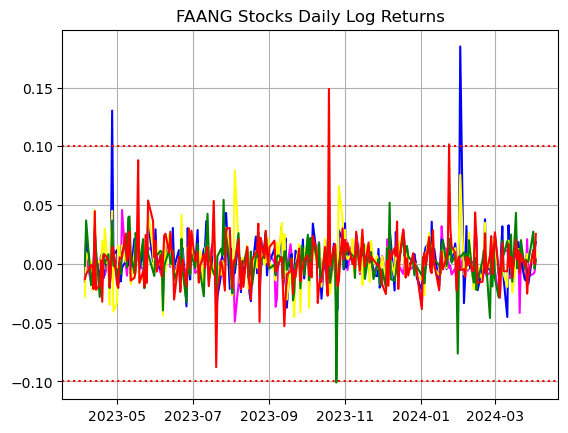

In [153]:
plt.plot(df_log_ret['AAPL'], color='magenta')
plt.plot(df_log_ret['META'], color='blue')
plt.plot(df_log_ret['AMZN'], color='yellow')
plt.plot(df_log_ret['GOOG'], color='green')
plt.plot(df_log_ret['NFLX'], color='red')

plt.axhline(y=0.1, ls='dotted', color='red')
plt.axhline(y=-0.1, ls='dotted', color='red')
plt.title('FAANG Stocks Daily Log Returns')
plt.grid(True)

### Parametric VaR

The Variance-covariance is a parametric method which assumes, almost always, that the returns are normally distributed. In this method, we first calculate the mean and standard deviation of the log returns to derive the risk metric. Based on this assumption of normality, we can generalise:

$$ VaR = position \times (\mu - z \times \sigma) $$

<div align="center">

| Confidence Level | Value at Risk                 |
|:----------------:|:-----------------------------:|
|   90%            |    $$\mu - 1.29\times\sigma$$ |
|   95%            |    $$\mu - 1.64\times\sigma$$ |
|   99%            |    $$\mu - 2.33\times\sigma$$ |

</div>

Here, $\mu$ is the return, and $\sigma$ is the volatility; $z$ is the number of standard deviations from the mean. 

In [154]:
# calc the mean and std dev

mean = np.mean(df_log_ret['AAPL'])
stdev = np.std(df_log_ret['AAPL'])

# calc the VaR ar different conf intervals

var_90 = norm.ppf(1-0.90, mean, stdev)
var_95 = norm.ppf(1-0.95, mean, stdev)
var_99 = norm.ppf(1-0.99, mean, stdev)

In [155]:
# output the results in tabular form

table = [['90%', var_90], ['95%', var_95], ['99%', var_99]]
header = ['Confidence Level', "Value at Risk"]

print(tabulate(table, headers=header))

Confidence Level      Value at Risk
------------------  ---------------
90%                      -0.0154877
95%                      -0.0199054
99%                      -0.0281924


In [156]:
# define a Var function to calc for each stock

def VaR(ticker, cl=0.95):
    mean = np.mean(df_log_ret[ticker])
    stdev = np.std(df_log_ret[ticker])

    return np.around(100*norm.ppf(1-cl, mean, stdev), 4)

In [157]:
# VaR for each stock

print('Var for FAANG Stocks')
print('---'*15)
[print(f'VaR at 95% CL for {ticker:4} : {VaR(ticker)}%') for ticker in df_log_ret.columns]


Var for FAANG Stocks
---------------------------------------------
VaR at 95% CL for AAPL : -1.9905%
VaR at 95% CL for AMZN : -2.837%
VaR at 95% CL for META : -3.291%
VaR at 95% CL for NFLX : -3.3544%
VaR at 95% CL for GOOG : -2.6846%


[None, None, None, None, None]

### Visualizing VaR at 95% confidence level
<p align="center">
<img src="VaR.png">
</p>

Assume we have 1,000 shares of AAPL stocks on March 27th 2024, which is our most recent data point in our dataframe. We are now going to see what our maximum loss for the next day would be; calculated under a confidence interval set to 99%.

In [158]:
num_shares = 1000
current_price = df_close['AAPL'].iloc[0]
position = num_shares * current_price

aapl_var = position * var_99

print(f'Apple Holding Value: {position}')
print(f'Apple VaR at 99% Cl is: {aapl_var}')

Apple Holding Value: 169649.994
Apple VaR at 99% Cl is: -4782.837346588544


In [159]:
# for clarity sake, we can also apply the formula directly to get the same result

position * (mean + norm.ppf(1-0.99) * stdev) == aapl_var

True

### Scaling VaR
Moving on, let's compute the 5 Day VaR; to scale it, we simply multiply the value by the square root of the time period:

$$VaR = position \times (\mu - z \times \sigma) \times \sqrt T $$

where, $T$ is the forecast period/horizon.

In [160]:
forecast_period = 5
f_var_90 = var_90 * np.sqrt(forecast_period)
f_var_95 = var_95 * np.sqrt(forecast_period)
f_var_99 = var_99 * np.sqrt(forecast_period)

In [161]:
forecast_table = [['90%', f_var_90],['95%', f_var_95],['99%', f_var_99]]
forecast_table_header = ['Confidence Level', '5-Day Forecast Value at Risk']
print(tabulate(forecast_table, forecast_table_header))

Confidence Level      5-Day Forecast Value at Risk
------------------  ------------------------------
90%                                     -0.0346315
95%                                     -0.0445099
99%                                     -0.0630401


Let's now do the *5-Day 99% VaR* for AAPL

In [162]:
aapl_5day_var = position * f_var_99

print(f'Apple Holding Value: {position}')
print(f'Apple VaR at 99% confidence level is: {aapl_5day_var}')

Apple Holding Value: 169649.994
Apple VaR at 99% confidence level is: -10694.749432296707


Text(0.5, 1.0, 'VaR 95%, Scaled by Time')

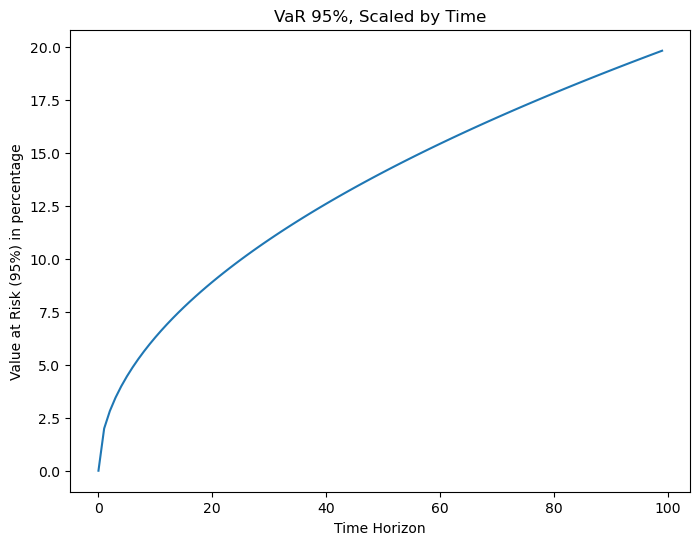

In [163]:
# scaled VaR over varying time periods

plt.figure(figsize=(8,6))
plt.plot(range(100), [-100 * var_95 * np.sqrt(x) for x in range(100)])
plt.xlabel("Time Horizon")
plt.ylabel("Value at Risk (95%) in percentage")
plt.title("VaR 95%, Scaled by Time")

### Historical VaR

Asset returns do not need to follow a normal distribution. An alternative is to use sorted returns to compute VaR. This method used historical data where returns are sorted in ascending order to calculate maximum possible loss for a given confidence level.

In [164]:
# use quantile function for historical VaR

historical_var_90 = df_log_ret['AAPL'].quantile(0.10)
historical_var_95 = df_log_ret['AAPL'].quantile(0.05)
historical_var_99 = df_log_ret['AAPL'].quantile(0.01)

In [165]:
historical_var_table = [['90%', historical_var_90],['95%', historical_var_95],['99%', historical_var_99]]

print(tabulate(historical_var_table,headers=header))

Confidence Level      Value at Risk
------------------  ---------------
90%                      -0.0119527
95%                      -0.0185203
99%                      -0.0364462


# Expected Shortfall
While Var is a reasonable measure of risk, it only holds when assumptions of noomrlaity holds. If said assumptions are not met, we might underestimate the risk if we observe a fat tail. Or, we might overestimate the risk if the tail is thinner. Expected shortfall or *Conditional Value at Risk* (**CVaR**) is an estimate of expected shortfall sustained in the absolute worst $1 - x%$ of scenarios. It is defined as the average loss based on the returns that are **lower** than the Var threshold. 

Assuming we have $n$ stock return, then the expected shortfall is as follows:

$$ CVaR =  \frac{1}{n} \times \sum_{i=1}^n R_i [R \le hVaR_{cl}] $$

where, $R$ is the returns, $hVaR$ is the historical VaR and $cl$ is the confidence level.

In [166]:
cvar_90 = df_log_ret['AAPL'][df_log_ret['AAPL'] <= historical_var_90].mean()
cvar_95 = df_log_ret['AAPL'][df_log_ret['AAPL'] <= historical_var_95].mean()
cvar_99 = df_log_ret['AAPL'][df_log_ret['AAPL'] <= historical_var_99].mean()

In [167]:
cvar_table = [['90%', cvar_90],['95%', cvar_95],['99%', cvar_99] ]
cvar_header = ['Confidence Level', 'Conditional Value At Risk']
print(tabulate(cvar_table,headers=cvar_header))

Confidence Level      Conditional Value At Risk
------------------  ---------------------------
90%                                  -0.0222956
95%                                  -0.0294116
99%                                  -0.0424588


### MonteCarlo VaR
The Monte Carlo simulation approach has a number of similarities to historical simulation. It allows us to use actual historical distributions rather than having to assume normal returns. As returns are assumed to follow a normal distribution, we could generate $n$ simulated returns with the same mean and standard deviation (derived from the daily returns) and then sorted in ascending order to calculate maximum possible loss for a given confidence level.

In [168]:
# seed setting for reproducibility

np.random.seed(12345)

# no. of simulations

n_sims = 5000

# simulate returns and sort them

sim_returns = np.random.normal(mean, stdev, n_sims)

# use percentile functions for MonteCarlo VaR

mcvar_90 = np.percentile(sim_returns, 10)
mcvar_95 = np.percentile(sim_returns, 5)
mcvar_99 = np.percentile(sim_returns, 1)

In [169]:
mcvar_table = [['90%', mcvar_90],['95%', mcvar_95],['99%', mcvar_99]]
print(tabulate(mcvar_table,headers=header))

Confidence Level      Value at Risk
------------------  ---------------
90%                      -0.0152983
95%                      -0.0196981
99%                      -0.0275871


### Portfolio VaR
Knowing the returns and volatilities of our assets under a given portfolio, we cancompute the VaR for the entire portfolio. Which is what we will do now, assuming equal weighting for all our stocks that make up our portfolio.

In [170]:
# assign weights

wts = np.array([0.2, 0.2, 0.2, 0.2, 0.2])[:, np.newaxis]
wts

array([[0.2],
       [0.2],
       [0.2],
       [0.2],
       [0.2]])

### Portfolio Return

In [171]:
# stock returns

df_log_ret[:5]

,AAPL,AMZN,META,NFLX,GOOG
Date,,,,,
2024-04-03,0.004786,0.009474,0.018664,0.025510,0.003203
2024-04-02,-0.007023,-0.001548,0.012177,-0.000163,-0.004034
2024-04-01,-0.008492,0.003266,0.011813,0.011427,0.027466
2024-03-28,-0.010615,0.003054,-0.016908,-0.010157,0.002104
2024-03-27,0.020991,0.008544,-0.004102,-0.025284,0.001581


In [172]:
port_log_returns = np.dot(df_log_ret, wts)
port_log_returns.flatten()

array([ 1.23272811e-02, -1.18156904e-04,  9.09605667e-03, -6.50450855e-03,
        3.46080297e-04, -4.47652216e-03, -4.31528990e-03,  8.30979629e-03,
       -1.03118997e-02,  1.37604821e-02,  4.02465756e-03,  1.93637092e-02,
       -1.38819956e-02,  9.29770408e-03, -1.68306017e-03,  1.54054107e-02,
       -8.03111482e-03, -1.75400149e-03,  1.76164827e-02, -1.60350794e-03,
       -1.92672068e-02, -1.43415882e-02,  8.26750543e-03,  1.14230553e-02,
       -8.59707178e-03,  9.09406208e-03, -1.05564184e-02, -4.13068692e-03,
        2.40609094e-02,  2.72493354e-03, -6.80084981e-03, -1.27932470e-02,
        3.21360765e-03,  1.72350125e-02, -1.47851380e-02, -7.13895714e-03,
        1.01435883e-02, -1.33116824e-03,  1.11427737e-02, -3.25010591e-03,
       -5.45276264e-03,  5.11999858e-02,  1.26861165e-02, -2.85913552e-02,
       -1.40602778e-02,  8.64928293e-03,  3.57581502e-03,  1.25648663e-02,
        2.57945074e-02,  8.66546501e-03,  1.61072688e-03,  1.24147504e-02,
        1.79064870e-02, -

In [173]:
port_log_returns_mean = port_log_returns.mean()
port_log_returns_mean

0.0019514850344821853

### Portfolio Volatility

In [174]:
# covariance matrix

df_log_ret.cov()

,AAPL,AMZN,META,NFLX,GOOG
AAPL,0.000148,0.000085,0.000100,0.000096,0.000098
AMZN,0.000085,0.000348,0.000252,0.000143,0.000173
META,0.000100,0.000252,0.000490,0.000155,0.000174
NFLX,0.000096,0.000143,0.000155,0.000479,0.000113
GOOG,0.000098,0.000173,0.000174,0.000113,0.000300


In [175]:
# portfolio volatility

port_log_returns_mean_stdev = np.sqrt(multi_dot([wts.T, df_log_ret.cov(), wts]))
port_log_returns_mean_stdev.flatten()[0]

0.013476598529058907

### Portfolio Position

In [176]:
# portfolio position

port_position = (df_close.iloc[0] * num_shares).sum()
port_position

1645250.0

In [177]:
# compute portfolio VaR at varying CL

portvar_90 = norm.ppf(1-0.90, port_log_returns_mean, port_log_returns_mean_stdev).flatten()[0]
portvar_95 = norm.ppf(1-0.95, port_log_returns_mean, port_log_returns_mean_stdev).flatten()[0]
portvar_99 = norm.ppf(1-0.99, port_log_returns_mean, port_log_returns_mean_stdev).flatten()[0]

In [178]:
portvar_95

-0.020215546935009234

### Portfolio VaR


In [179]:
# output results in tabular form
port_table = [['90%', portvar_90],['95%', portvar_95],['99%', portvar_99]]
port_header = ['Confidence Level', 'Value At Risk']
print(tabulate(port_table,headers=port_header))

Confidence Level      Value At Risk
------------------  ---------------
90%                      -0.0153195
95%                      -0.0202155
99%                      -0.0293998


In [180]:
# iterate over tickers

for stock in df_close.columns:
    pos = df_close[stock].iloc[0] * num_shares
    pvar = pos * VaR(stock)

    print(f'{stock} Holding Value: {pos:0.4}') 
    print(f'{stock} VaR at 95% confidence level: {pvar:0.4}')
    print()

print(f'Portfolio Holding Value: {port_position:0.4}')
print(f'Portoflio VaR at 95% confidence level: {port_position * portvar_95:0.4}')

AAPL Holding Value: 1.696e+05
AAPL VaR at 95% confidence level: -3.377e+05

AMZN Holding Value: 1.824e+05
AMZN VaR at 95% confidence level: -5.175e+05

META Holding Value: 5.067e+05
META VaR at 95% confidence level: -1.668e+06

NFLX Holding Value: 6.301e+05
NFLX VaR at 95% confidence level: -2.114e+06

GOOG Holding Value: 1.564e+05
GOOG VaR at 95% confidence level: -4.198e+05

Portfolio Holding Value: 1.645e+06
Portoflio VaR at 95% confidence level: -3.326e+04


Hence, the **VaR95%** of our portfolio valued at **$1,645,000** is computed to be **$33,260**.

### References
- Numpy documentation https://docs.scipy.org/doc/numpy/

- Scipy documentation https://docs.scipy.org/doc/scipy/reference/

- Paul Wilmott (2007), Paul Wilmott introduces Quantitative Finance